# **3.Example**

**Initial libraries**
https://developers.google.cn/earth-engine/apidocs/ee-image-expression


In [1]:
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

Installing geemap ...


In [2]:
import ee
import geemap

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=mnHTlgF-amEz0BF10Ign-SClUdd74-djIX-KBeP6cI8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiJop6xZYp9oJET8hlgRKrh7DA_1fREGWwWP57XEXhdpTeATF3mdD0

Successfully saved authorization token.


**ROI import**

In [3]:
roi = ee.Geometry.Polygon(
        [[[34.5,-1.5],[34.6,-1.5],[34.6,-1.6],[34.5,-1.6],[34.5,-1.5]]])
roi_map = geemap.Map()
roi_map.add_basemap('HYBRID')
roi_map.centerObject(roi, 9)
roi_map.addLayer(roi,{},"roi")
roi_map.addLayerControl() # This line is not needed for ipyleaflet-based Map.
roi_map

Map(center=[-1.550000196346228, 34.55000000000001], controls=(WidgetControl(options=['position', 'transparent_…

# **Image collection filter**

In this case study,we can going to use USGS Landsat 8 Surface Reflectance Tier 1.

Let's filter the ImageCollection by roi ,date and cloud cover.

In [4]:
startDate = ee.Date("2013-1-1");
endDate  =ee.Date("2020-12-31");
images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate(startDate, endDate) \
    .filter(ee.Filter.lte("CLOUD_COVER", 10))


Let's filter the ImageCollection by cloud mask.

In [5]:
def cloud_mask(image):
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5
  snowBitMask = 1 << 4
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cloudsBitMask).eq(0)
  mask3 = qa.bitwiseAnd(snowBitMask).eq(0)
  mask = mask1.add(mask2).add(mask3)
  return image.updateMask(mask.gte(1))
images = images.map(cloud_mask)

Get images properties


In [ ]:
print(images.getInfo())

{'type': 'ImageCollection', 'bands': [], 'id': 'LANDSAT/LC08/C01/T1_SR', 'version': 1639397895472414, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['cfmask', 'cloud', 'fmask', 'global', 'l8sr', 'landsat', 'lc08', 'reflectance', 'sr', 'usgs'], 'visualization_1_bands': 'B5,B4,B3', 'thumb': 'https://mw1.google.com/ges/dd/images/LANDSAT_SR_thumb.png', 'visualization_1_max': '30000.0', 'description': '<p>This dataset is the atmospherically corrected\nsurface reflectance from  the Landsat 8 OLI/TIRS sensors.\nThese images contain 5 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and two thermal infrared (TIR) bands processed to orthorectified\nbrightness temperature</p><p>These data have been atmospherically corrected using\n<a href="https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LAS

How many Landsat 8 images (2013-2019) are available for the study area?

In [6]:
print(images.size().getInfo())

53


Let's add the first image to the Map.

In [7]:
First_image_Map = geemap.Map()
First_image_Map.add_basemap('HYBRID')
First_image_Map.centerObject(roi, 9)

first_image = images.first()

vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 6000,
  'gamma': 1.4,
}
First_image_Map.addLayer(first_image, vis_params, 'first image')
First_image_Map.addLayer(roi, {}, 'roi')
First_image_Map.addLayerControl()
First_image_Map

Map(center=[-1.550000196346228, 34.55000000000001], controls=(WidgetControl(options=['position', 'transparent_…

# **NDWI calculation and Water mask extraction**

Calculate NDWI




# **Area change analysis**

Define function to extract water

In [7]:
def calNDVI(image):
    ndvi=image.normalizedDifference(['B5','B4'])
    return ndvi
def calEVI(image):
    evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B5'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    })
    #evi=image.expression('2.5*(B5-B4)/(B5+6*B4-7.5*B2+1)',{'B5':image.select('B5'),'B4':image.select('B4'),'B2':image.select('B2')})
    return evi
def calVDSI(image):
    vsdi=image.expression('1-(B6-B2)-(B4-B2)',{'B6':image.select('B6'),'B4':image.select('B4'),'B2':image.select('B2')})
    return vsdi

In [12]:
def calNDVI(image):
    ndvi=image.normalizedDifference(
        ['B5','B4']
        )
    return ndvi
def calEVI(image):
    evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B5'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    })
    return evi

In [8]:
def VI(cal_VI):    
  for year in range(2013,2020+1):
    print(year)
    yearly_images = images.filterDate(str(year)+"-01-01",str(year)+"-12-31")
    yearly_ndvi_images = yearly_images.map(cal_VI)
    yearly_mean_ndvi_extent = yearly_ndvi_images.mean()
    stats = yearly_mean_ndvi_extent.multiply(ee.Image.pixelArea()).reduceRegion(
      reducer = ee.Reducer.sum(),
      geometry = roi,
      scale = 30
    ).get('nd').getInfo()
    print(stats)
    areaList.append(stats/1000000)
  print(areaList)

Calculate area

In [13]:
cloud_threshold= 10
images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_threshold)

areaList = []

VI(calNDVI)
#VI(calEVI)

2013
63767562.46613039
2014
62261183.32976054
2015
71385965.20037258
2016
64191809.20780621
2017
54073360.110346355
2018
66047177.14548649
2019
62462694.41821365
2020
71757991.52416742
[63.76756246613039, 62.261183329760534, 71.38596520037258, 64.1918092078062, 54.07336011034636, 66.04717714548649, 62.46269441821365, 71.75799152416742]


In [9]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Load a Landsat 8 image.
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Compute the EVI using an expression.
evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B5'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    })

# Define a map centered on San Francisco Bay.
map_evi = folium.Map(location=[37.4675, -122.1363], zoom_start=9)

# Add the image layer to the map and display it.
map_evi.add_ee_layer(
    evi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'evi')
display(map_evi)

plot

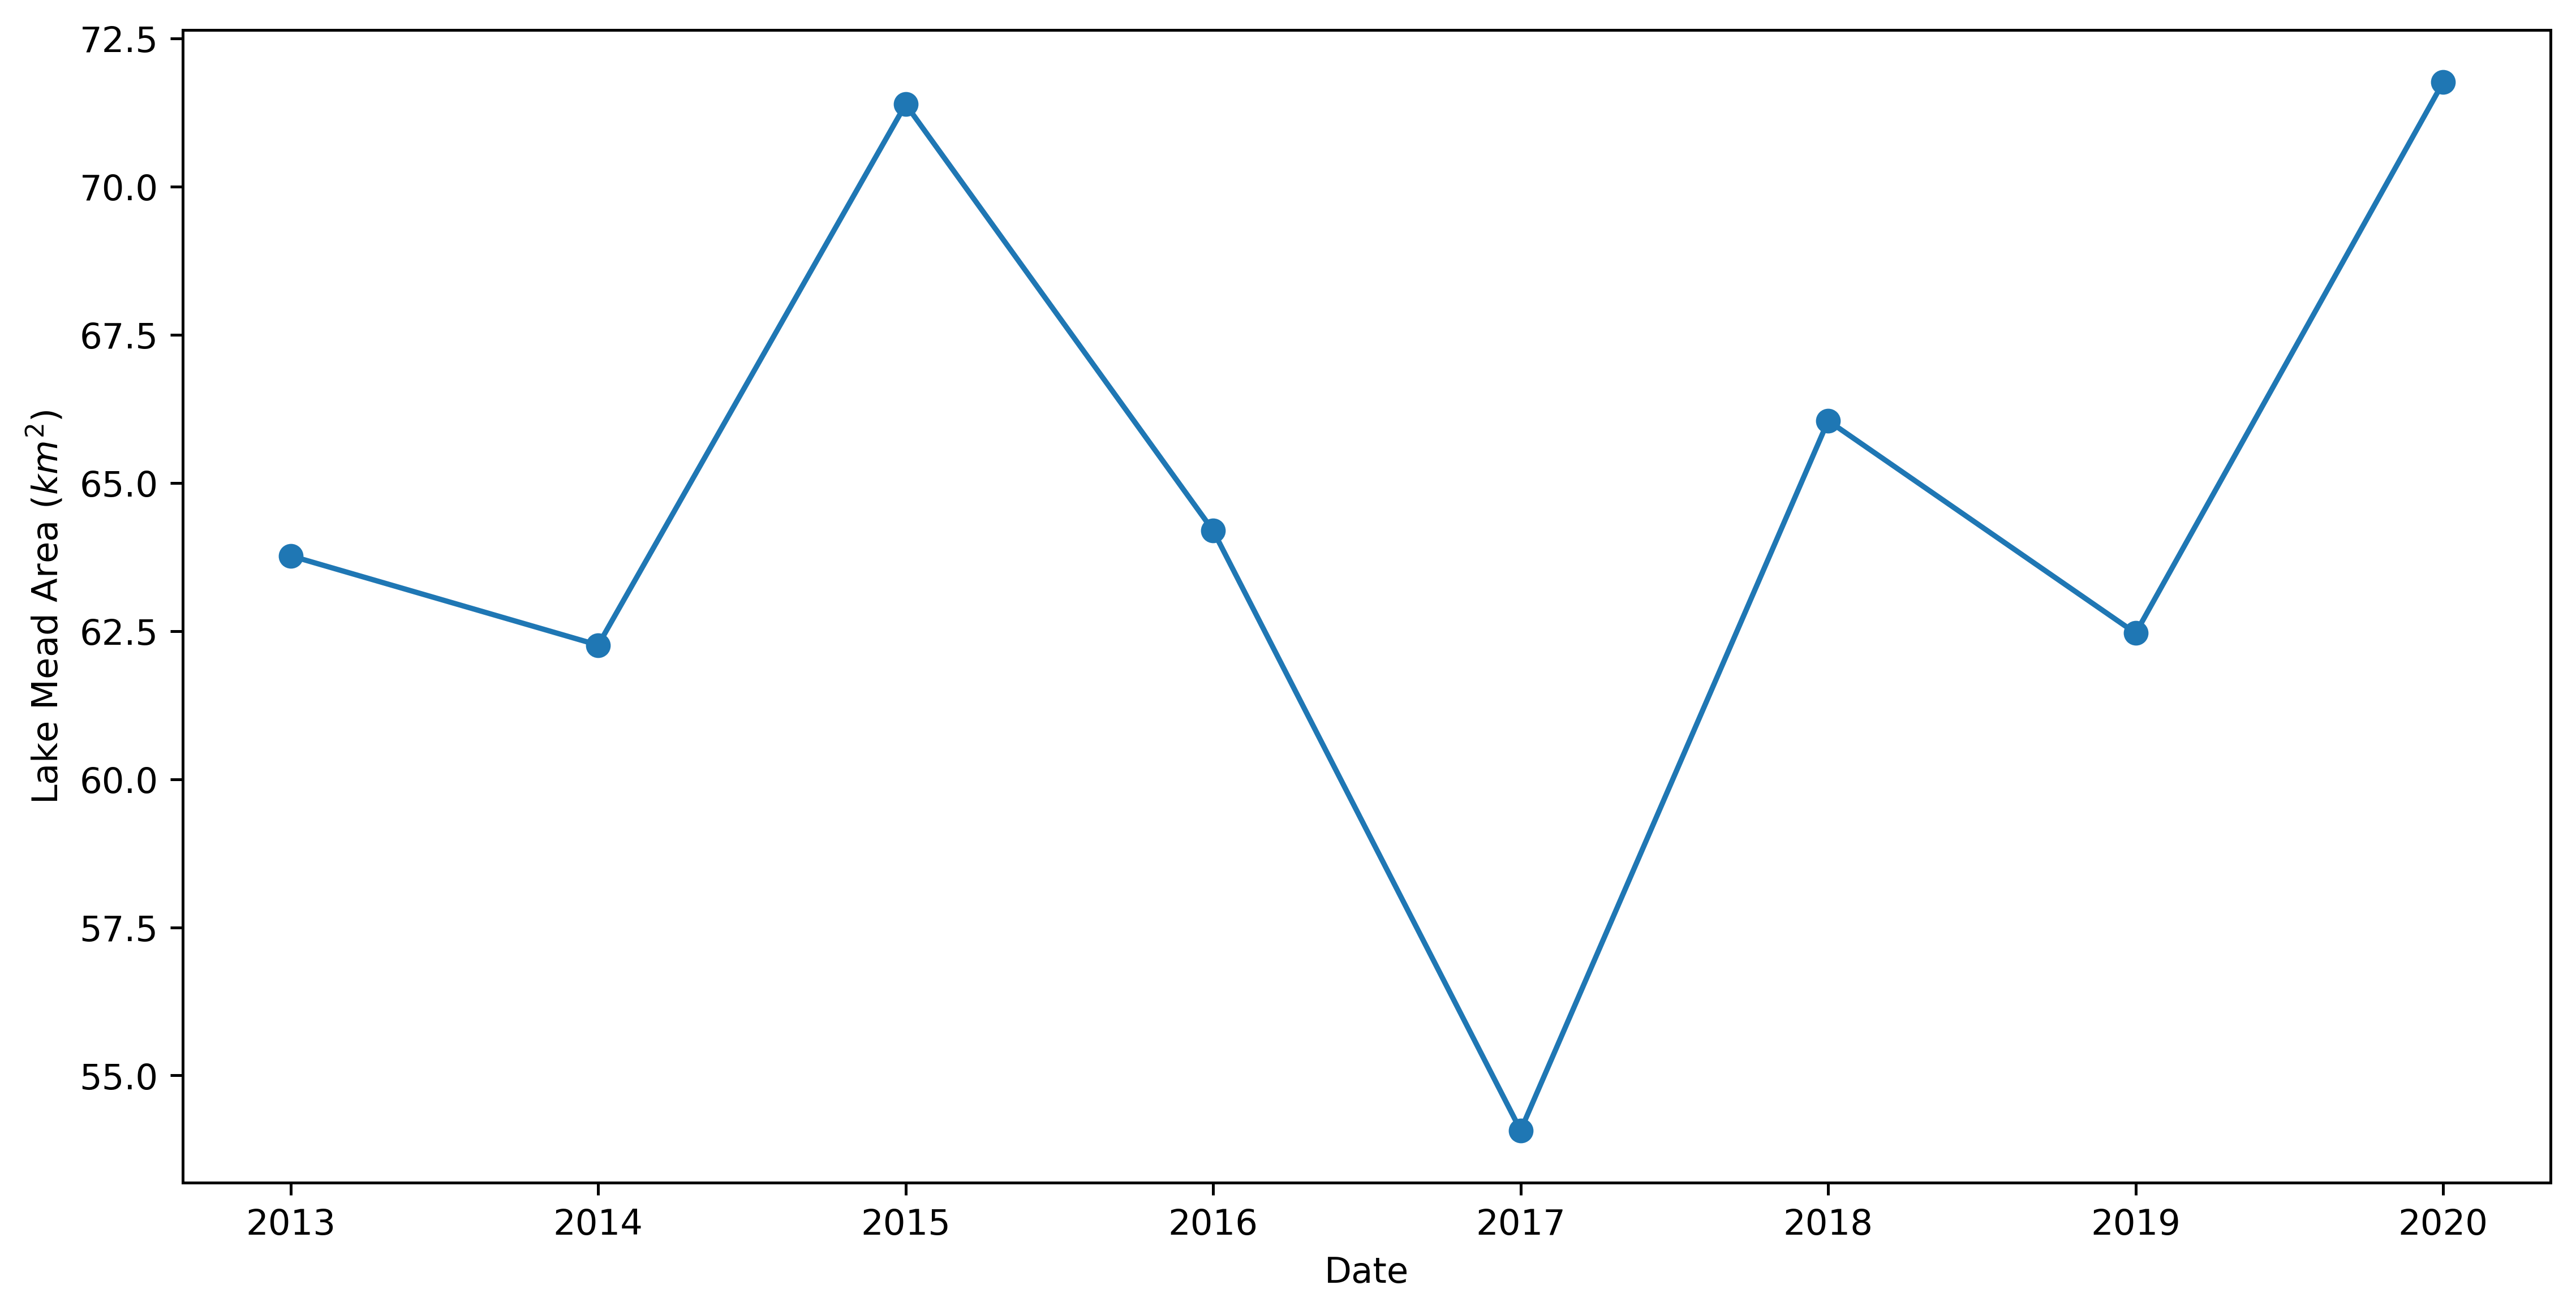

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt 

fig= plt.figure(figsize=(12,6),dpi=450)

x = range(2013,2020+1)

plt.plot(x, areaList, marker='o')
plt.xlabel('Date')
plt.ylabel('NDVI Area ($km^2$)')
plt.show()

In [10]:
def difference(cal_VI,year1,year2):
  print(year1,year2)
  yearly_image1 = images.filterDate(str(year1)+"-01-01",str(year1)+"-12-31")
  yearly_image2 = images.filterDate(str(year2)+"-01-01",str(year2)+"-12-31")
  yearly_ndvi_image1 = yearly_image1.map(calNDVI)
  yearly_ndvi_image2 = yearly_image2.map(calNDVI)
  yearly_mean_ndvi_extent1 = yearly_ndvi_image1.mean()
  yearly_mean_ndvi_extent2 = yearly_ndvi_image2.mean()
  difference_image = yearly_mean_ndvi_extent2.subtract(yearly_mean_ndvi_extent1)
  map_evi = folium.Map(location=(-1.5,34.5), zoom_start=9)
  stats = difference_image.multiply(ee.Image.pixelArea()).reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = roi,
    scale = 30
  ).get('nd').getInfo()
  print(stats)
  # Add the image layer to the map and display it.
  map_evi.add_ee_layer(
      difference_image, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'ndvi')
  display(map_evi)
  return difference_image

In [ ]:
!apt install proj-bin libproj-dev libgeos-dev

In [14]:
from mpl_toolkits.basemap import Basemap
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10), sharey=True, sharex=True,dpi=450) 
# Add a title for the series of plots 
figure.suptitle('Vegetation Index (NDVI) Change Detectionfrom 2013 to 2015', 
                      fontsize=32, fontweight='bold') 
axes[0][0].set_title(u'from 2013 to 07-28',fontsize=20,fontweight='bold')
axes[0][1].set_title(u'from 07-28 to 08-13',fontsize=20,fontweight='bold') 
axes[0][2].set_title(u'from 08-13 to 08-29',fontsize=20,fontweight='bold')
axes[1][0].set_title(u'from 08-29 to 09-14',fontsize=20,fontweight='bold') 
axes[1][1].set_title(u'from 09-14 to 09-30',fontsize=20,fontweight='bold')
axes[0][0].imshow(difference(calNDVI,2013,2014),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[0][1].imshow(difference(calNDVI,2014,2015),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[0][2].imshow(difference(calNDVI,2015,2016),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[1][0].imshow(difference(calNDVI,2016,2017),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[1][1].imshow(difference(calNDVI,2017,2018),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[1][2].imshow(difference(calNDVI,2018,2019),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
# Set up the basemap for each subplot 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[0][0]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[0][1]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white')
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[0][2]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[1][0]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[1][1]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (106 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


ModuleNotFoundError: ignored

# **Data export**

Export an image to Google Drive

In [12]:
task = ee.batch.Export.image.toDrive(image=images.first(),region=roi,description='image_first',folder='gee_test',scale=30,crs='EPSG:4326')
task.start()

Inspect current exporting status

In [13]:
task.status()

{'creation_timestamp_ms': 1641216593912,
 'description': 'image_first',
 'id': 'JAN4ZQ5OBW2LLWUTCTLJ7O7Y',
 'name': 'projects/earthengine-legacy/operations/JAN4ZQ5OBW2LLWUTCTLJ7O7Y',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1641216593912}